# HW5_97110069

##### import libraries

In [1]:
import pandas as pd
import datetime
import numpy as np
import jdatetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 8]
warnings.filterwarnings('ignore')
import os

# P1

##### get TEPIX data and clean dates

In [129]:

def adjust_time(df):
    df['Date'] = df['Date'].apply(lambda x : str(x))
    df['Date'] = df['Date'].apply(lambda x : f'{x[:4]}/{x[4:6]}/{x[6:]}')
    df['Date'] = df['Date'].apply(lambda x : jdatetime.datetime.strptime(str(x),'%Y/%m/%d'))

df1 = pd.read_excel('shakhes_kol.xlsx' )
df1 = df1.iloc[::1]
adjust_time(df1)
df1.set_index(['Date'],inplace=True)
df1.rename(columns = {'Value':'shakhes'},inplace = True)
shakhes = df1
shakhes

,shakhes
Date,
1401-03-08 00:00:00,1534057.1
1401-03-07 00:00:00,1553401.9
1401-03-04 00:00:00,1564487.5
1401-03-03 00:00:00,1555689.0
1401-03-02 00:00:00,1557210.6
...,...
1390-01-10 00:00:00,24486.0
1390-01-09 00:00:00,24486.6
1390-01-08 00:00:00,24287.8


##### simple linear regression. The function returns the coeffs and intercept with their t-stats.

In [111]:
from sklearn.linear_model import LinearRegression
from scipy import stats

def simple_regression(df, y_column, x_column):
    df.dropna(inplace = True)
    linear_regression = LinearRegression()
    if len(df) == 0:
        return None
    
    y = (df[y_column] - risk_free_rate).to_numpy()
    x = (df[x_column] - risk_free_rate).to_numpy()
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    linear_regression.fit(y, x)
    
    params = np.append(linear_regression.intercept_,linear_regression.coef_)
    predictions = linear_regression.predict(x)
    newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    coef_t_stat = myDF3.iloc[1]['t values']
    intercept_t_stat = myDF3.iloc[0]['t values']
    return linear_regression.coef_[0], linear_regression.intercept_, coef_t_stat, intercept_t_stat

##### make dataframe with alphas and betas with their t-stats for 20 random funds

In [125]:
import random

def get_shamsi_datetime(x):
    x = str(x)
    date = jdatetime.datetime.strptime(x, '%Y/%m/%d')
    return date


def get_monthly_return(monthly_data):
    monthly_data['nav_shift'] = monthly_data['nav'].shift(1)
    monthly_data['nav_return'] = (monthly_data['nav'] - monthly_data['nav_shift']) / monthly_data['nav_shift']
    monthly_data['shakhes_shift'] = monthly_data['shakhes'].shift(1)
    monthly_data['shakhes_return'] = (monthly_data['shakhes'] - monthly_data['shakhes_shift']) / monthly_data['shakhes_shift']

'''we get all file addresses in data directory and randomly choose 20 of the files.'''
path = 'data/'
dir_list = os.listdir(path)
dir_list.remove('.ipynb_checkpoints')
random_files = random.sample(range(len(dir_list)), 20)
number = 0

'''lists to append data for each fund'''
indexes = []
betas = []
beta_t_stats = []
alpha_t_stats = []
alphas = []
volumes = []

'''make all_data that is a dataframe that contains all funds data'''
all_data = shakhes.copy(deep = True)

'''we place fixed risk free rate : 0.25 ^ (1 / 12)'''
risk_free_rate = 0.0187 

'''for each fund we compute the alpha and beta and stats'''
for index in random_files:
    df = pd.read_csv('data/' + dir_list[index])
    df = df[['قیمت ابطال','تاریخ','ارزش خالص دارایی‌ها']]
    df = df.iloc[::-1]
    df.rename(columns = {'تاریخ':'date','قیمت ابطال':'nav' }, inplace = True)
    df['date'] = df['date'].apply(lambda x: get_shamsi_datetime(x))
    df.set_index('date', inplace = True)
    df = df.merge(shakhes, left_index = True, right_index = True)
    all_data = all_data.merge(df[['nav']].rename(columns = {'nav':f'nav_{number}'}), left_index =True, right_index =True)
    df['date_'] = df.index 
    df['month'] = df['date_'].apply(lambda x : x.month)
    df['year'] = df['date_'].apply(lambda x : x.year)
    df = df.groupby(['year', 'month']).apply(lambda x:  x.iloc[0])
    df.drop(columns = ['month', 'year', 'date_'],inplace = True)
    get_monthly_return(df)
    df = df.dropna()
    beta, alpha , beta_t_stat, alpha_t_stat = simple_regression(df, 'nav_return', 'shakhes_return')
    beta_t_stats.append(beta_t_stat)
    alpha_t_stats.append(alpha_t_stat)
    indexes.append( dir_list[index])
    betas.append(beta[0])
    alphas.append(alpha[0])
    volumes.append(df['ارزش خالص دارایی‌ها'].mean())
    number += 1


final_data = pd.DataFrame({'betas':betas, 'alphas':alphas, 'beta_tstat':beta_t_stats, 'alpha_tstats':alpha_t_stats, 'volumes':volumes}, index = indexes)
final_data
    

,betas,alphas,beta_tstat,alpha_tstats,volumes
اختصاصی بازارگردانی توسعه معادن و فلزات آرمان.csv,1.055888,0.010715,13.422,1.056,3.885746e+12
اعتماد آفرین پارسیان.csv,7.125665,0.033366,8.804,0.370,2.689292e+13
آهنگ سهام کیان.csv,0.955782,0.002828,24.092,0.574,1.028979e+12
اختصاصی بازارگردانی افتخار حافظ.csv,0.402196,0.024361,2.804,1.580,5.724874e+11
اختصاصی بازارگردان صنعت مس.csv,0.720990,0.015224,8.451,1.490,4.620637e+12
اختصاصی بازارگردانی امید ایرانیان.csv,0.792538,0.032822,8.123,3.028,3.392198e+12
اختصاصی بازارگردانی امید ایرانیان (1).csv,0.792538,0.032822,8.123,3.028,3.392198e+12
اختصاصی بازارگردانی بانک سینا.csv,0.559650,0.021737,5.393,1.855,6.776514e+11
اختصاصی بازارگردانی گنجینه سپهر صادرات.csv,0.528641,0.012257,4.555,0.983,4.946727e+12
اختصاصی بازارگردانی تدبیرگران فردا.csv,0.435997,0.046032,3.098,2.491,5.362765e+12


<AxesSubplot:xlabel='alphas', ylabel='Count'>

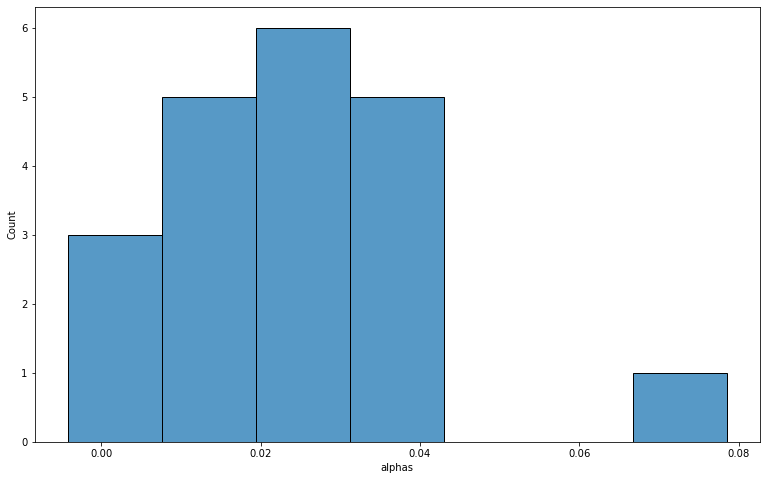

In [118]:
'''alphas histogram'''
sns.histplot(final_data['alphas'])

<AxesSubplot:xlabel='alpha_tstats', ylabel='Count'>

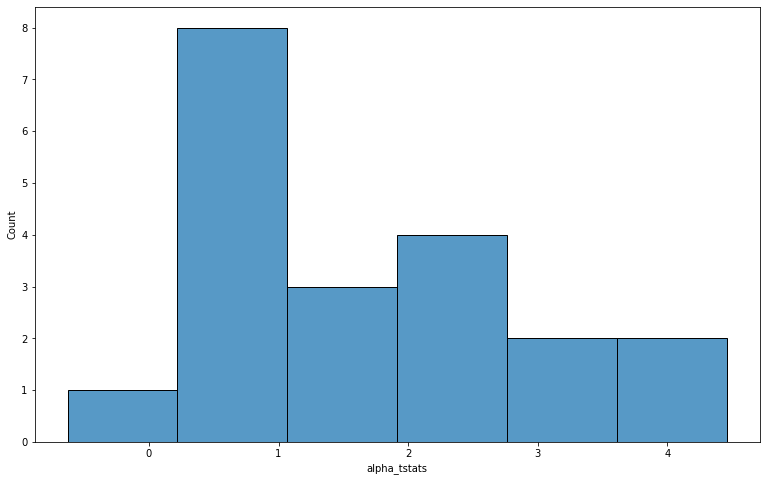

In [122]:
'''alphas t-stats histogram'''
sns.histplot(final_data['alpha_tstats'])

<AxesSubplot:xlabel='volumes', ylabel='alphas'>

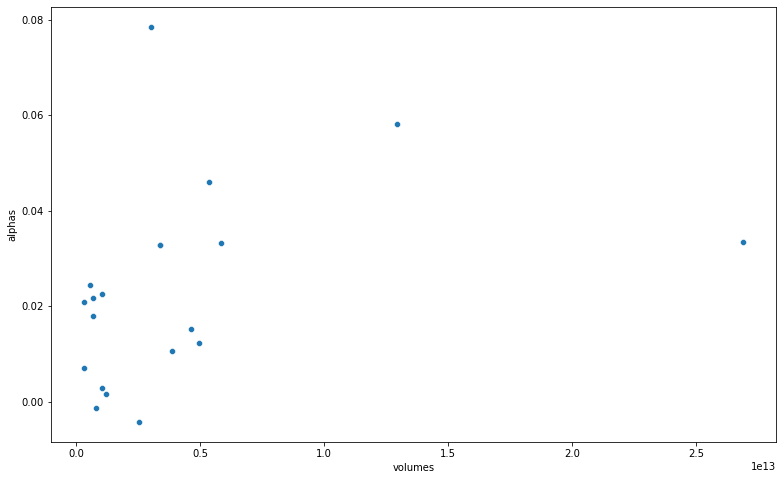

In [127]:
'''see that how alphas change when volume changes'''
sns.scatterplot(data =final_data, x = 'volumes', y = 'alphas')

<AxesSubplot:xlabel='volumes', ylabel='alpha_tstats'>

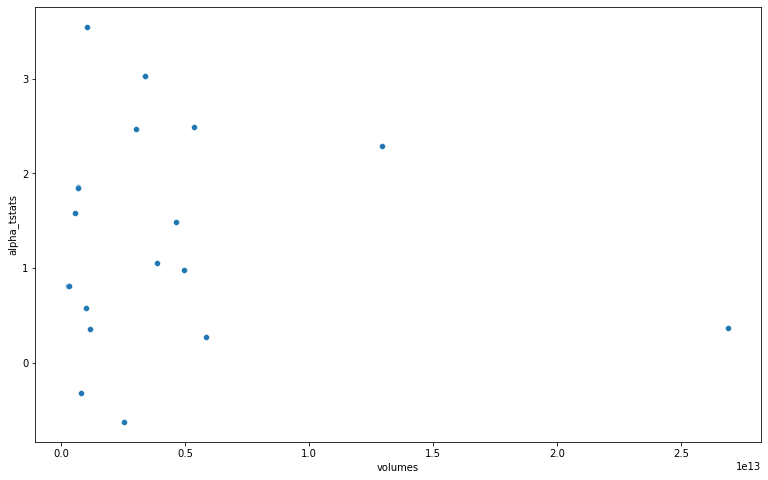

In [128]:
'''how alpha t-stats change with colume'''
sns.scatterplot(data =final_data, x = 'volumes', y = 'alpha_tstats')

<AxesSubplot:xlabel='alphas', ylabel='alpha_tstats'>

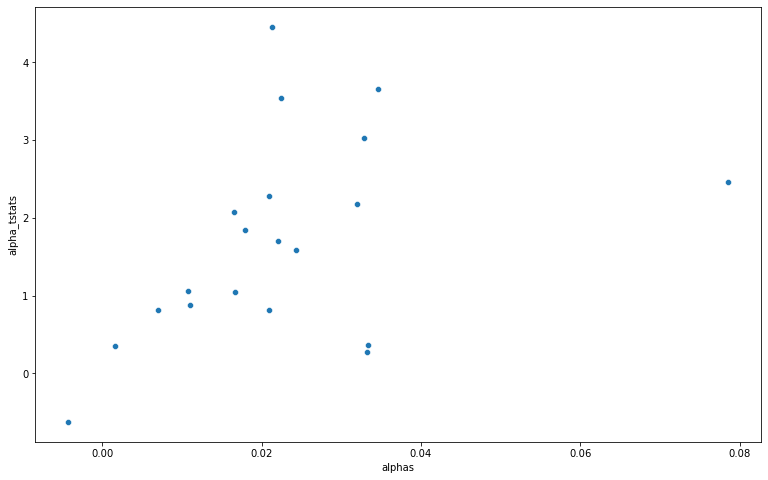

In [121]:
'''to see which alphas are significant'''
sns.scatterplot(data =final_data, x = 'alphas', y = 'alpha_tstats')

##### Comparison of Jensen and our results
In Jensens paper there is very little evidence that any individual fund was able to do significantly better than that which we expected from mere random chance. But here in the funds that we checked, we obtain a few results:
1 - almost all the alphas are positive
2 - less than half of the alphas are significant 
3 - as the fund volume (size) increases the alpha grows
4 - higher alphas have higher t-stats and are more significant

as the results show big alphas are significant. This could be for many reasons:
1 - we set constant risk free rate
2 - there are many other variables that we havn't applied in regression (multi-factor models)
3 - inefficiency in tehran stock markets.

# P2

In [130]:
all_data = all_data[::-1]
all_data

,shakhes,nav_0,nav_1,nav_2,nav_3,nav_4,nav_5,nav_6,nav_7,nav_8,...,nav_10,nav_11,nav_12,nav_13,nav_14,nav_15,nav_16,nav_17,nav_18,nav_19
1401-03-04 00:00:00,1564487.5,10968877,44525,18648269,680044,12137190,1262388,1262388,4588144,8012810,...,215476,779431,1002000,38835,1801295,33238455,14759,1004202,205544,9979916
1401-03-03 00:00:00,1555689.0,10948308,44469,18579718,677826,12221695,1267563,1267563,4538124,8013035,...,211805,779288,1001500,38794,1743134,33162221,14688,1003331,203448,9923678
1401-03-02 00:00:00,1557210.6,10973007,44481,18585435,680437,12272611,1270774,1270774,4673523,8043230,...,213179,786459,1001000,38776,1721233,33183783,14692,1003893,203403,9934519
1401-03-01 00:00:00,1582222.7,11018124,44603,18928263,684570,12388580,1294017,1294017,4942197,8260598,...,218064,806997,1000500,38839,1750615,33577246,14916,1004354,207464,10033449
1401-02-31 00:00:00,1579686.7,11014474,44547,18876465,679277,12372113,1284813,1284813,5073748,8286997,...,216817,807129,1000000,38818,1758079,33469123,14915,1003753,206968,9996633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396-06-21 00:00:00,83469.2,1122653,17392,1132514,933842,1841868,1266665,1266665,944802,1364629,...,10950,1041035,1012404,13808,2293879,1227654,14680,1068005,12794,1082704
1396-06-20 00:00:00,83369.1,1126581,17383,1132382,934344,1846256,1258326,1258326,944848,1364757,...,10919,1039929,1011807,13804,2282536,1227815,14673,1067429,12776,1081887
1396-06-19 00:00:00,83255.7,1123178,17361,1138138,937767,1851633,1256010,1256010,944880,1364799,...,10958,1038470,1011218,13784,2284648,1228639,14651,1068247,12751,1083171
1396-06-15 00:00:00,83675.3,1126192,17311,1140072,943065,1904682,1261441,1261441,945069,1365138,...,11016,1037214,1008921,13756,2290965,1248981,14729,1066024,13023,1085171


##### 1-difference of ranking by abnormal and excess return?
when we sort funds by their excess return we are comparing funds by their return. because we subtract risk free rate from all the funds returns. In this method we are not looking at the risk of investments. But when we compare funds by abnormal return we are actually including the risks in comparing funds

In [131]:
half_period = len(all_data) // 2
first_period_excess_returns = []
second_period_excess_returns = []

first_period_abnormal_returns = []
second_period_abnormal_returns = []

def excess_return(all_data, column):
    first_return = (all_data[column].iloc[half_period] - all_data[column].iloc[0]) / all_data[column].iloc[0]
    second_return = (all_data[column].iloc[-1] - all_data[column].iloc[half_period]) / all_data[column].iloc[half_period]
    first_period_excess_returns.append(first_return)
    second_period_excess_returns.append(second_return)

def add_column_return(df, column):
    df[f'{column}_shift'] = df[column].shift(1)
    df[f'{column}_return'] = (df[column] - df[f'{column}_shift']) / df[f'{column}_shift']
    df.drop(columns = [f'{column}_shift'], inplace = True)

def abnormal_return(all_data, column):
    add_column_return(all_data, column)
    _, alpha1, _, _ = simple_regression(all_data[[f'{column}_return', 'shakhes_return']].iloc[:half_period], f'{column}_return', 'shakhes_return')
    _, alpha2, _, _ = simple_regression(all_data[[f'{column}_return', 'shakhes_return']].iloc[half_period:], f'{column}_return', 'shakhes_return')
    first_period_abnormal_returns.append(alpha1[0])
    second_period_abnormal_returns.append(alpha2[0])
    return


add_column_return(all_data, 'shakhes')
columns = all_data.columns.copy(deep = True)
for column in columns:
    if column in ['shakhes', 'shakhes_return']:
        continue
    excess_return(all_data, column)
    abnormal_return(all_data, column)


returns = pd.DataFrame({'first_half_excess_return':first_period_excess_returns, 'second_half_excess_return':second_period_excess_returns, 'first_half_abnormal_return':first_period_abnormal_returns,
                       'second_half_abnormal_return':second_period_abnormal_returns})
returns


,first_half_excess_return,second_half_excess_return,first_half_abnormal_return,second_half_abnormal_return
0,-0.772407,-0.548967,-0.006981,0.001393
1,-0.436407,-0.310552,-0.023165,0.081488
2,-0.860749,-0.560145,-0.003258,-0.003101
3,0.728371,-0.196887,-0.022985,0.002566
4,-0.701654,-0.472353,-0.006933,0.001623
5,0.378490,-0.275298,-0.019016,0.008948
6,0.378490,-0.275298,-0.019016,0.008948
7,-0.591764,-0.492879,-0.018963,-0.010648
8,-0.770251,-0.258385,-0.015559,-0.020434
9,1.190532,-0.521389,-0.021257,-0.012274


### excess returns

In [132]:
percentiles = returns.quantile(0.5)
loser_loser = len(returns[(returns['first_half_excess_return'] < percentiles['first_half_excess_return']) & 
                          (returns['second_half_excess_return'] < percentiles['second_half_excess_return']) ])
loser_winner = len(returns[(returns['first_half_excess_return'] < percentiles['first_half_excess_return']) & 
                          (returns['second_half_excess_return'] > percentiles['second_half_excess_return']) ])
winner_loser = len(returns[(returns['first_half_excess_return'] > percentiles['first_half_excess_return']) & 
                          (returns['second_half_excess_return'] < percentiles['second_half_excess_return']) ])
winner_winner = len(returns[(returns['first_half_excess_return'] > percentiles['first_half_excess_return']) & 
                          (returns['second_half_excess_return'] > percentiles['second_half_excess_return']) ])
print('The probability of being a loser in period 1 and being a loser in period 2 is ', loser_loser / len(returns))
print('The probability of being a loser in period 1 and being a winner in period 2 is ', loser_winner / len(returns))
print('The probability of being a winner in period 1 and being a loser in period 2 is ', winner_loser/ len(returns))
print('The probability of being a winner in period 1 and being a winner in period 2 is ', winner_winner/ len(returns))


The probability of being a loser in period 1 and being a loser in period 2 is  0.4
The probability of being a loser in period 1 and being a winner in period 2 is  0.1
The probability of being a winner in period 1 and being a loser in period 2 is  0.1
The probability of being a winner in period 1 and being a winner in period 2 is  0.4


The results for excess return are reliable because we only look at simple return. So there is no bias in are results. The results show that funds with historical high returns have higher returns in the future. We can explain this by the fact that the funds with higher returns have higher risk (beta) and the high return is probably because of investing in riskier assets.


### abnormal returns

In [133]:
loser_loser = len(returns[(returns['first_half_abnormal_return'] < percentiles['first_half_abnormal_return']) & 
                          (returns['second_half_abnormal_return'] < percentiles['second_half_abnormal_return']) ])
loser_winner = len(returns[(returns['first_half_abnormal_return'] < percentiles['first_half_abnormal_return']) & 
                          (returns['second_half_abnormal_return'] > percentiles['second_half_abnormal_return']) ])
winner_loser = len(returns[(returns['first_half_abnormal_return'] > percentiles['first_half_abnormal_return']) & 
                          (returns['second_half_abnormal_return'] < percentiles['second_half_abnormal_return']) ])
winner_winner = len(returns[(returns['first_half_abnormal_return'] > percentiles['first_half_abnormal_return']) & 
                          (returns['second_half_abnormal_return'] > percentiles['second_half_abnormal_return']) ])
print('The probability of being a loser in period 1 and being a loser in period 2 is ', loser_loser / len(returns))
print('The probability of being a loser in period 1 and being a winner in period 2 is ', loser_winner / len(returns))
print('The probability of being a winner in period 1 and being a loser in period 2 is ', winner_loser/ len(returns))
print('The probability of being a winner in period 1 and being a winner in period 2 is ', winner_winner/ len(returns))


The probability of being a loser in period 1 and being a loser in period 2 is  0.2
The probability of being a loser in period 1 and being a winner in period 2 is  0.3
The probability of being a winner in period 1 and being a loser in period 2 is  0.3
The probability of being a winner in period 1 and being a winner in period 2 is  0.2


But for abnormal return we cant say the same. There is no evidence that shows that funds with higher historical alphas should have higher alphas in the future. (this is equivalent to the fact that a fund that has beat the market will not necessarily beat the market in the future)